# Capstone Project VII

This data set contains statistics, in arrests per 100,000 residents, for assault, murder and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

In [41]:
# Load libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from pca import pca

from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

In [2]:
# load in the dataset
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [3]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [4]:
# Convert data types
df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [5]:
# Check for missing values
df.isnull().sum()

# There are no missing values

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [6]:
# Statistics summary
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


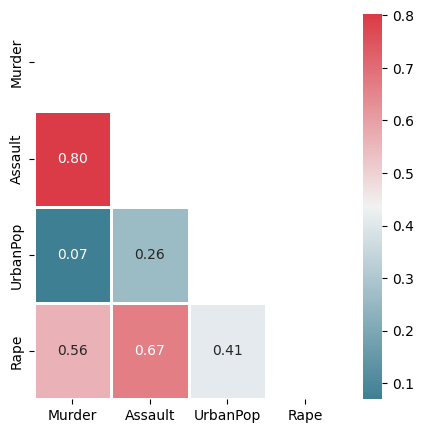

In [7]:
# drop city column
dfV2 = df.drop(columns=['City'])

# Create a plot of the data using all features to show the positive and negative correlations between them.
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# get correlations
corrs = dfV2.corr()

# Plot figsize
fig, ax = plt.subplots(figsize=(5, 5))

# to mask mirrored side of heatmap
dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

It can be seen here that every correlation is positive however some are a lot stronger than others. For example, Murder and Assault have quite a strong positive correlation wheras Murder and UrbanPop is extrememly weak.

In [8]:
# Scale the data due to there being large differences between the values of variables
scaled = StandardScaler().fit_transform(dfV2)
df_scale = pd.DataFrame(scaled, columns = dfV2.columns)
df_scale.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


Now the data is scaled it is time to run a PCA analysis.

In [9]:
# Show how each component attributes itself to the explained variance
pca = PCA().fit(df_scale)

pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

Text(0, 0.5, 'Cumulative Variance')

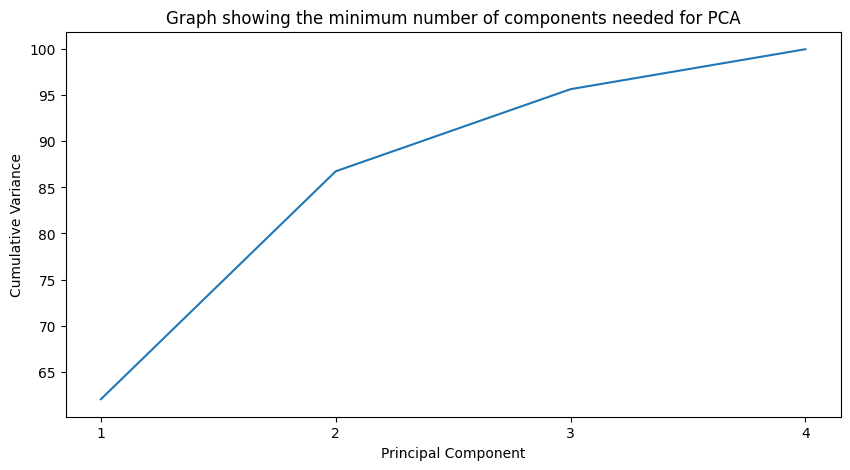

In [10]:
# Create a graph showing the minimum number of components needed for our analysis

X = np.arange(1, 5, step=1)
plt.figure(figsize=(10,5))
sns.lineplot(x=X, y=np.cumsum(pca.explained_variance_ratio_)*100)

plt.title('Graph showing the minimum number of components needed for PCA')
plt.xlabel('Principal Component')
plt.xticks(X)
plt.ylabel('Cumulative Variance')

The graph above shows us that component 1 contains 62% of all explained variances within the data. Component 1 and 2 combined contain 86.74% of all explained variance. This means that over 50% of the data is now gone however an explanation value as to how the features deviate or affect on another of 86.74% is still maintained. I will continue with 2 components for the rest of the analysis. 

In [16]:
# Base model off of two components
pca = PCA(n_components = 2)
PC = pca.fit_transform(df_scale)

In [17]:
# transform components into a pandas data frame
PC_df = pd.DataFrame(data = PC, columns = ['PC1', 'PC2'])
PC_df['City'] = df['City']
PC_df.head()

,PC1,PC2,City
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


I will perform both Hierachical Clustering and K-means with these data and compare the results

# K-Means Analysis

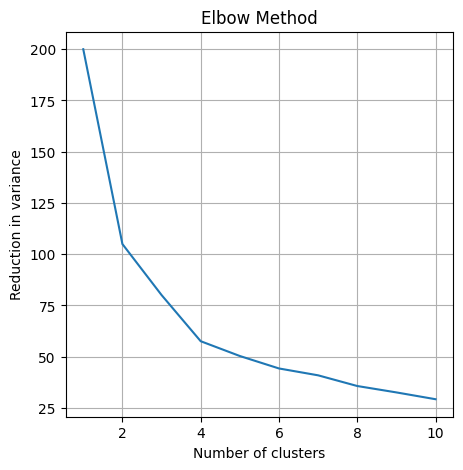

In [35]:
# determine the best number of clusters using the elbow method
plt.figure(figsize = (5,5))

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in variance')
plt.grid()

It can be seen that 4 is the best number of clusters as this is where the 'elbow' bends

In [37]:
# fit k-means to dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, random_state = 24)
ykmeans = kmeans.fit_predict(scaled)

print('K-means Silhouette Score: ', silhouette_score(scaled, ykmeans))

K-means Silhouette Score:  0.33968891433344395


# Agglomerative Clustering

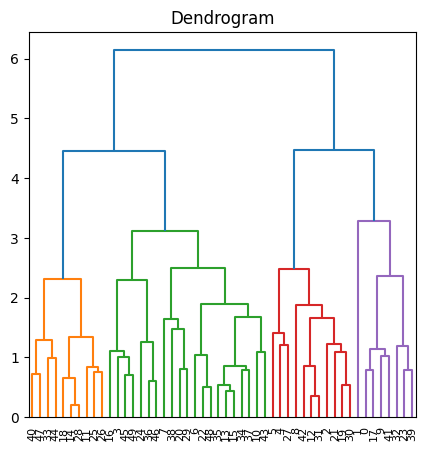

In [42]:
# Create dendrogram
plt.figure(figsize = (5,5))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(scaled, method = 'complete'))

Text(0, 0.5, 'Principal Component 2')

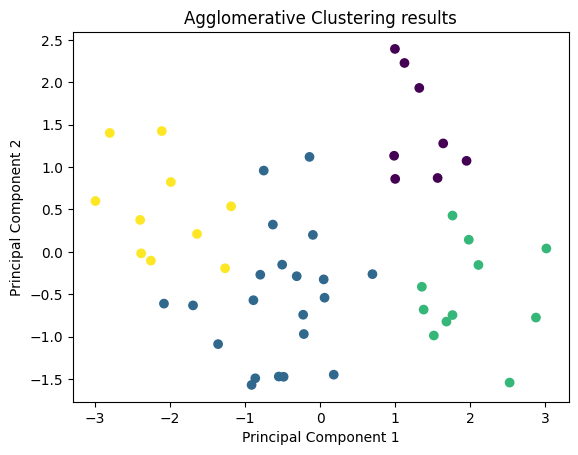

In [55]:
# fit agglomerative clustering to dataset
cluster = AgglomerativeClustering(n_clusters = 4, metric = 'euclidean', linkage = 'complete')
cluster_predict = cluster.fit_predict(scaled)

plt.scatter(PC[:,0], PC[:,1], c=cluster.labels_)
plt.title('Agglomerative Clustering results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [46]:
print('Agglomerative Cluster Silhouette Score: ', silhouette_score(scaled, cluster_predict))

Agglomerative Cluster Silhouette Score:  0.31595507426164543


In [60]:
# Use the k-Means model predictions to analysis results
df['cluster labels'] = ykmeans
df.head()

,City,Murder,Assault,UrbanPop,Rape,cluster labels
0,Alabama,13.2,236.0,58.0,21.2,3
1,Alaska,10.0,263.0,48.0,44.5,2
2,Arizona,8.1,294.0,80.0,31.0,2
3,Arkansas,8.8,190.0,50.0,19.5,3
4,California,9.0,276.0,91.0,40.6,2


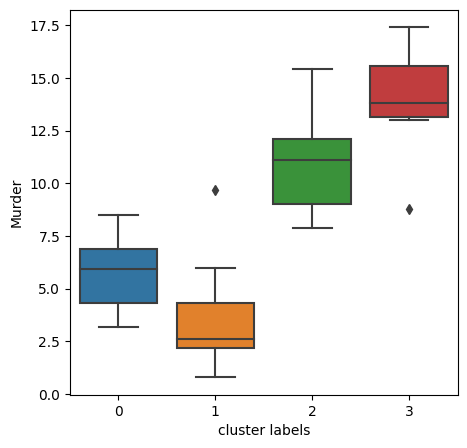

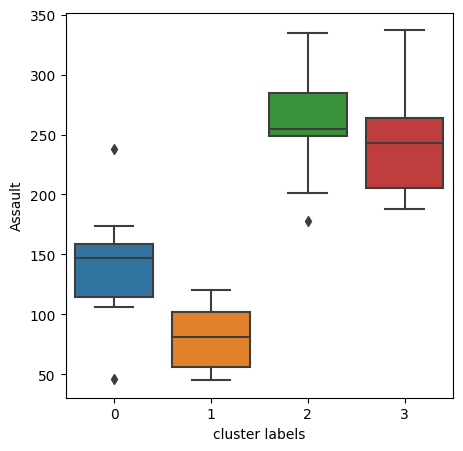

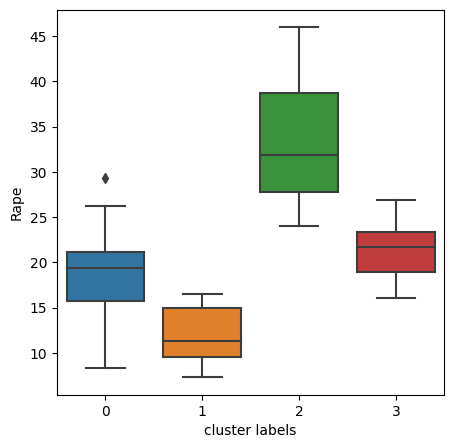

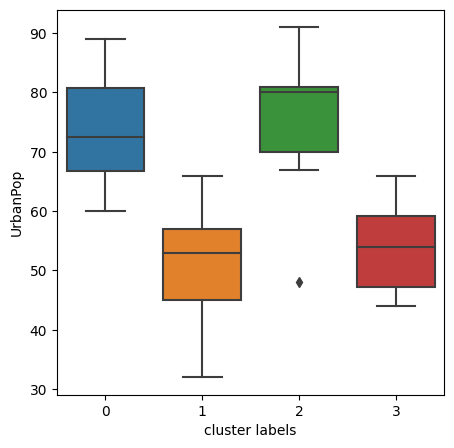

In [65]:
# Create box plots of each variable and it's clusters
variables = ['Murder', 'Assault', 'Rape', 'UrbanPop']
for i in variables:
    plt.figure(figsize=(5,5))
    sns.boxplot(x='cluster labels', y=i, data=df)

# Summary

Here I have investigated the data set US Arrests (description at the beginning). I have used unsupervised learning models such as Principal Component Analysis (PCA), K-means Clustering and Agglomerative Clustering. Conducting a PCA resulted in being able to reduce the original 4 features down to 2 main principal components while still retaining over 86% of the total degree of explanation as to how the features deviate or effect on another. I used the elbow method and created a dendrogram to help figure out the best number of clusters to use. From both of these graphs it is safe to say that 4 is an appropriate number of clusters. When using 4 clusters it can be seen that the K-means model has a higher silhouette score then the Agglomerative Clustering model. This score is still only 0.34 though meaning the clusters are quite closely related to one another.<br>

From the box plots we can see that cluster 1 includes the safest cities, with Murder, Assault and Rape all being at their lowest in this cluster. Cluster 0 is then the next safest with Murder, Assault and Rape all being at their second lowest points here. Clusters 2 and 3 are the most dangerous cities with Murder, Assault and Rape values being higher here than clusters 0 and 1. Interestingly enough clusters 1 and 3 are similar in their Urban Population percentage and clusters 0 and 2 are quite similar as well. This shows that the Urban Population percentage may not be related to levels of Murder, Assault and Rape.